In [1]:
import cv2
from keras.layers import Input, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Dropout, Add, concatenate
from tensorflow.keras.layers import BatchNormalization
from keras.models import Model,load_model
from tensorflow.keras.optimizers import RMSprop
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import glob
from matplotlib import pyplot as plt
import tensorflow as tf
import math

In [2]:
from PIL import Image
filelist = glob.glob('../Dataset/*')
images = np.array([np.array(Image.open(fname)) for fname in filelist])

In [3]:
images.shape

(1836, 240, 240, 3)

In [6]:
images = (images-np.min(images))/(np.max(images)-np.min(images))

In [7]:
np.max(images)

1.0

In [8]:
input_img = Input(shape = (240,240,3))
train_X,valid_X,train_ground,valid_ground = train_test_split(images,images,test_size=0.2,random_state=42)

In [7]:
def DCRBlock(features,kernelsize):
    c1 = Conv2D(kernelsize*1.5,(3,3),activation='relu',padding='same')(features)
    c1 = BatchNormalization()(c1)

    conca1 = concatenate([features,c1])
    
    c2 = Conv2D(kernelsize*2,(3,3),activation='relu',padding='same')(conca1)
    c2 = BatchNormalization()(c2)

    conca2 = concatenate([features,conca1,c2])
    
    c3 = Conv2D(kernelsize,(3,3),activation='relu',padding='same')(conca2)
    c3 = BatchNormalization()(c3)

    ress = Add()([features,c3])

    return ress

In [9]:
def UNetWithDCR(input_img,kernelsize):

    conv1 = Conv2D(kernelsize, (3, 3), activation='relu', padding='same')(input_img)
    dcr1 = DCRBlock(conv1,kernelsize)
    m1 = MaxPooling2D()(dcr1)

    conv2 = Conv2D(kernelsize*2, (3, 3), activation='relu', padding='same')(m1)
    dcr2 = DCRBlock(conv2,kernelsize*2)
    m2 = MaxPooling2D()(dcr2)

    conv3 = Conv2D(kernelsize*3,(3,3), activation='relu', padding='same')(m2)
    dcr3 = DCRBlock(conv3,kernelsize*3)
    m3 = MaxPooling2D()(dcr3)

    u3 = UpSampling2D()(m3)
    c5 = Conv2D(kernelsize,(3,3),activation='relu',padding='same')(u3)
    c6 = Conv2D(kernelsize,(3,3),activation='relu',padding='same')(dcr3)
    con3 = concatenate([c5,c6])

    u2 = UpSampling2D()(con3)
    c3 = Conv2D(kernelsize,(3,3),activation='relu', padding='same')(u2)
    c4 = Conv2D(kernelsize,(3,3),activation='relu', padding='same')(dcr2)
    con2 = concatenate([c3,c4])
    
    u1 = UpSampling2D()(con2)
    c1 = Conv2D(kernelsize,(3,3),activation='relu', padding='same')(u1)
    c2 = Conv2D(kernelsize,(3,3),activation='relu', padding='same')(dcr1)
    con = concatenate([c1,c2])
    ddcr1 = DCRBlock(con,kernelsize*2)

    convfinal = Conv2D(1,1,activation='sigmoid',padding='same')(ddcr1)

    return convfinal

In [10]:
opt = RMSprop(learning_rate=1e-3)
autoencoder = Model(input_img, UNetWithDCR(input_img,16))
autoencoder.compile(loss='mean_squared_error', optimizer = opt)

In [11]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 240, 240, 24  3480        ['conv2d[0][0]']                 
                                )                                                             

In [12]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=16,epochs=15,verbose=1,validation_data=(valid_X, valid_ground))

Epoch 1/15
91/91 [==============================] - 2329s 26s/step - loss: 0.0177 - val_loss: 0.0688
Epoch 2/15
91/91 [==============================] - 2328s 26s/step - loss: 0.0022 - val_loss: 0.0283
Epoch 3/15
91/91 [==============================] - 2330s 26s/step - loss: 0.0010 - val_loss: 0.0161
Epoch 4/15
91/91 [==============================] - 2275s 25s/step - loss: 7.3662e-04 - val_loss: 0.0031
Epoch 5/15
91/91 [==============================] - 2126s 23s/step - loss: 4.8239e-04 - val_loss: 0.0062
Epoch 6/15
91/91 [==============================] - 2122s 23s/step - loss: 4.3574e-04 - val_loss: 6.7408e-04
Epoch 7/15
91/91 [==============================] - 2121s 23s/step - loss: 2.9623e-04 - val_loss: 0.0050
Epoch 8/15
91/91 [==============================] - 2125s 23s/step - loss: 2.4893e-04 - val_loss: 0.0057
Epoch 9/15
91/91 [==============================] - 2121s 23s/step - loss: 2.0659e-04 - val_loss: 0.0015
Epoch 10/15
91/91 [==============================] - 2121s 23s/

In [13]:
pred = autoencoder.predict(valid_X)

Test Images


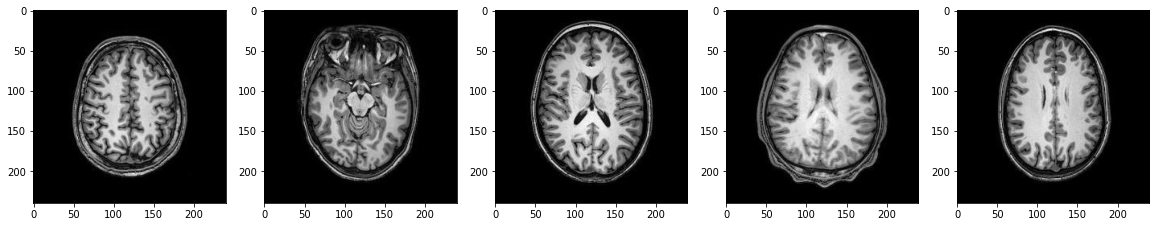

Reconstruction of Test Images


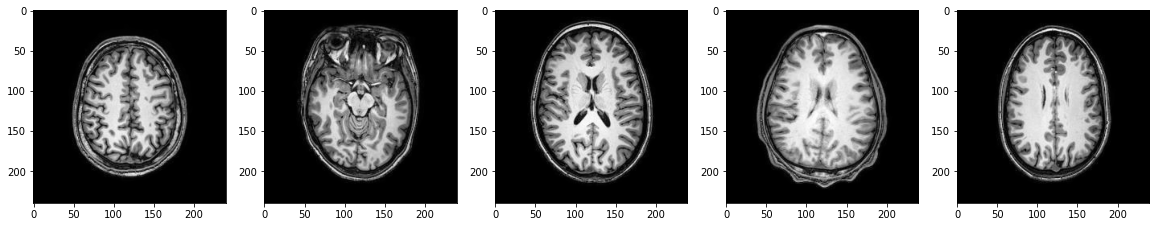

In [14]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [ ]:
autoencoder.save("Unet3layerAllImages15Epoch",save_format="h5")

In [10]:
autoencoder = load_model('Unet3layerAllImages15Epoch')

In [11]:
pred = autoencoder.predict(valid_X)

Test Images


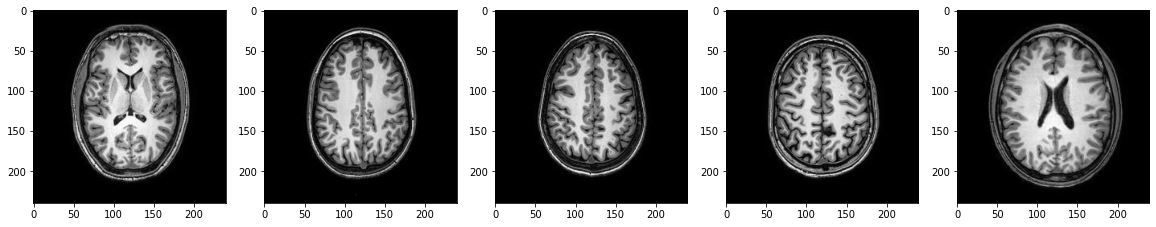

Reconstruction of Test Images


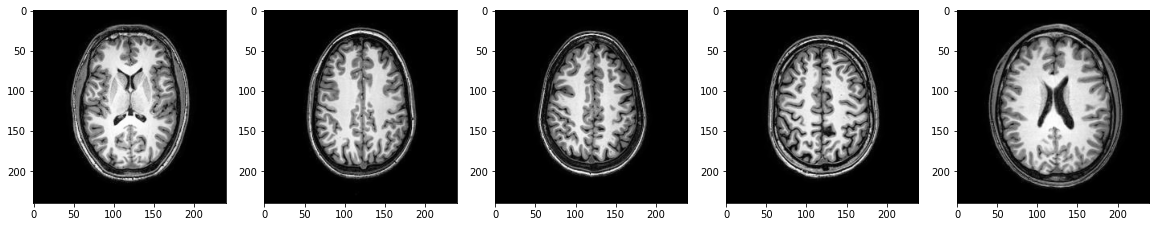

In [12]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(valid_ground[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [13]:
mse = np.mean((pred - valid_X)**2)
psnr_inputimage = 20 * math.log10(1/math.sqrt(mse))

In [14]:
print("PSNR of the reconstructed image",psnr_inputimage)

PSNR of the reconstructed image 33.091138848443585


In [15]:
[a,b,c,d]= np.shape(valid_X)
mean = 0
sigma = 0.05
gauss = np.random.normal(mean,sigma,(a,b,c,d))
noisy_images = valid_X + gauss

In [17]:
pred_noisy = autoencoder.predict(noisy_images)

Noisy Test Images


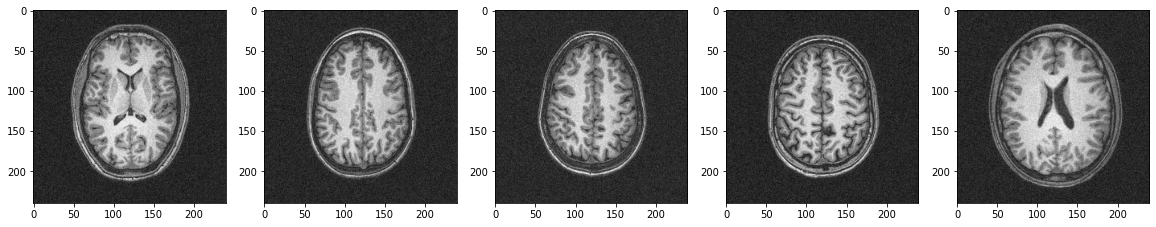

Reconstruction of Noisy Test Images


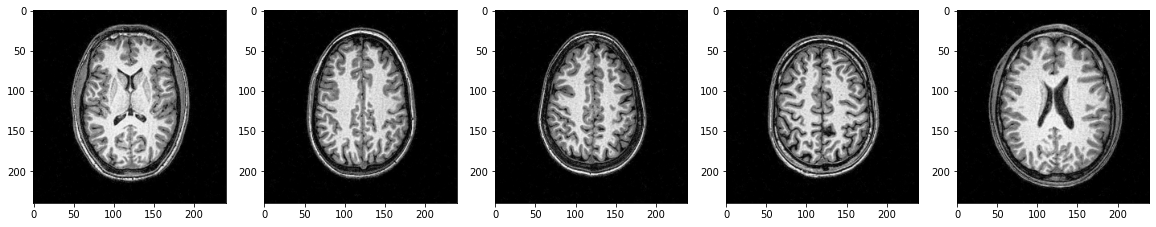

In [18]:
plt.figure(figsize=(20, 4))
print("Noisy Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(noisy_images[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Noisy Test Images")
for i in range(5):
    plt.subplot(1, 5, i+1 )
    plt.imshow(pred_noisy[i, ..., 0], cmap='gray')  
plt.show()

In [23]:
mse = np.mean((valid_X - pred_noisy)**2)
psnr_inputimage = 20 * math.log10(1/math.sqrt(mse))

In [24]:
print("PSNR of reconstructed noisy image",psnr_inputimage)

PSNR of reconstructed noisy image 29.20029739749515
